In [65]:
import pandas as pd
weather_df = pd.read_csv('data/weather_data_cleaned.csv')
crowd_df = pd.read_csv('data/sensor_data.csv')
crowd_df['timestamp'] = pd.to_datetime(crowd_df['timestamp'], utc=False)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=False)
weather_df = weather_df.rename(columns={'datetime': 'timestamp'})
weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)
crowd_df['timestamp'] = crowd_df['timestamp'].dt.tz_localize(None)

merged_df = pd.merge_asof(
    crowd_df,
    weather_df,
    on = 'timestamp',
    direction = 'nearest',
    tolerance = pd.Timedelta('60min')
)

merged_df = merged_df.set_index('timestamp')
sensor_cols = merged_df.columns[0:-14]
feature_cols = merged_df.columns[-14:]
sensor_cols

Index(['CMSA-GAKH-01_0', 'CMSA-GAKH-01_180', 'CMSA-GAWW-11_120',
       'CMSA-GAWW-11_300', 'CMSA-GAWW-12_115', 'CMSA-GAWW-12_295',
       'CMSA-GAWW-13_120', 'CMSA-GAWW-13_300', 'CMSA-GAWW-14_40',
       'CMSA-GAWW-14_220', 'CMSA-GAWW-15_30', 'CMSA-GAWW-15_210',
       'CMSA-GAWW-16_30', 'CMSA-GAWW-16_210', 'CMSA-GAWW-17_40',
       'CMSA-GAWW-17_220', 'CMSA-GAWW-19_115', 'CMSA-GAWW-19_295',
       'CMSA-GAWW-20_120', 'CMSA-GAWW-20_300', 'CMSA-GAWW-21_120',
       'CMSA-GAWW-21_300', 'CMSA-GAWW-23_109', 'CMSA-GAWW-23_289',
       'GACM-04_50', 'GACM-04_230', 'GASA-01-A1_135', 'GASA-01-A1_315',
       'GASA-01-A2_135', 'GASA-01-A2_315', 'GASA-01-B_135', 'GASA-01-B_315',
       'GASA-01-C_135', 'GASA-01-C_315', 'GASA-02-01_135', 'GASA-02-01_315',
       'GASA-02-02_135', 'GASA-02-02_315', 'GASA-03_105', 'GASA-03_285',
       'GASA-04_135', 'GASA-04_315', 'GASA-05-O_135', 'GASA-05-O_315',
       'GASA-05-W_135', 'GASA-05-W_315', 'GASA-06_95', 'GASA-06_275',
       'GASA-06-B_95', 'GASA-0

In [66]:
# Convert from wide to long format so that each row is:
# timestamp | location | crowd count | features...

In [67]:
# Melt the dataframe into long format
df_long = merged_df[sensor_cols].reset_index().melt(
    id_vars='timestamp',
    value_vars=sensor_cols,
    var_name='location',
    value_name='count'
)

# Merge feature columns back in
df_long = df_long.merge(
    merged_df[feature_cols].reset_index(),
    on='timestamp',
    how='left'
)

df_long.head()

,timestamp,location,count,hour,minute,day,month,weekday,is_weekend,temperature,dew_point,air_pressure,wind_speed,max_gust,rainfall,sunshine_duration,relative_humidity
0,2025-08-20 00:00:00,CMSA-GAKH-01_0,15,0,0,20,8,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
1,2025-08-20 00:03:00,CMSA-GAKH-01_0,1,0,3,20,8,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
2,2025-08-20 00:06:00,CMSA-GAKH-01_0,5,0,6,20,8,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
3,2025-08-20 00:09:00,CMSA-GAKH-01_0,4,0,9,20,8,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
4,2025-08-20 00:12:00,CMSA-GAKH-01_0,4,0,12,20,8,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75


In [68]:
# Add numeric location_id feature

In [69]:
# Create consistent integer labels for each location
location_map = {loc: i for i, loc in enumerate(sensor_cols)}
df_long['location_id'] = df_long['location'].map(location_map)

In [70]:
df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177600 entries, 0 to 177599
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          177600 non-null  datetime64[ns]
 1   location           177600 non-null  object        
 2   count              177600 non-null  int64         
 3   hour               177600 non-null  int64         
 4   minute             177600 non-null  int64         
 5   day                177600 non-null  int64         
 6   month              177600 non-null  int64         
 7   weekday            177600 non-null  int64         
 8   is_weekend         177600 non-null  int64         
 9   temperature        177600 non-null  float64       
 10  dew_point          177600 non-null  float64       
 11  air_pressure       177600 non-null  float64       
 12  wind_speed         177600 non-null  float64       
 13  max_gust           177600 non-null  float64 

In [71]:
# Add lag and rolling features 
# From exploration, we found that beyond lag_75, there seems to be no significant relationship with historic data

In [72]:
lags=[1,2,3,5,10,20,30,40,50,60,75]
rolling_windows=[3,5,10,20,40,60]

df_long = df_long.sort_values(['location_id', 'timestamp'])

# Create lag features per location
for lag in lags:
    df_long[f'lag_{lag}'] = df_long.groupby('location_id')['count'].shift(lag)

# Rolling mean features
for w in rolling_windows:
    df_long[f'roll_mean_{w}'] = df_long.groupby('location_id')['count'].rolling(w).mean().reset_index(0,drop=True)


In [73]:
df_long.head(60)

,timestamp,location,count,hour,minute,day,month,weekday,is_weekend,temperature,...,lag_40,lag_50,lag_60,lag_75,roll_mean_3,roll_mean_5,roll_mean_10,roll_mean_20,roll_mean_40,roll_mean_60
0,2025-08-20 00:00:00,CMSA-GAKH-01_0,15,0,0,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-08-20 00:03:00,CMSA-GAKH-01_0,1,0,3,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-08-20 00:06:00,CMSA-GAKH-01_0,5,0,6,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,NaN
3,2025-08-20 00:09:00,CMSA-GAKH-01_0,4,0,9,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,3.333333,NaN,NaN,NaN,NaN,NaN
4,2025-08-20 00:12:00,CMSA-GAKH-01_0,4,0,12,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,4.333333,5.8,NaN,NaN,NaN,NaN
5,2025-08-20 00:15:00,CMSA-GAKH-01_0,5,0,15,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,4.333333,3.8,NaN,NaN,NaN,NaN
6,2025-08-20 00:18:00,CMSA-GAKH-01_0,3,0,18,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,4.000000,4.2,NaN,NaN,NaN,NaN
7,2025-08-20 00:21:00,CMSA-GAKH-01_0,15,0,21,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,7.666667,6.2,NaN,NaN,NaN,NaN
8,2025-08-20 00:24:00,CMSA-GAKH-01_0,1,0,24,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,6.333333,5.6,NaN,NaN,NaN,NaN
9,2025-08-20 00:27:00,CMSA-GAKH-01_0,5,0,27,20,8,2,0,16.8,...,NaN,NaN,NaN,NaN,7.000000,5.8,5.8,NaN,NaN,NaN


In [74]:
# Remove NaNs
df_long = df_long.dropna()


In [75]:
df_long.head()

,timestamp,location,count,hour,minute,day,month,weekday,is_weekend,temperature,...,lag_40,lag_50,lag_60,lag_75,roll_mean_3,roll_mean_5,roll_mean_10,roll_mean_20,roll_mean_40,roll_mean_60
75,2025-08-20 03:45:00,CMSA-GAKH-01_0,2,3,45,20,8,2,0,16.8,...,2.0,5.0,7.0,15.0,0.666667,0.6,1.4,1.75,2.400,2.883333
76,2025-08-20 03:48:00,CMSA-GAKH-01_0,1,3,48,20,8,2,0,16.8,...,0.0,7.0,1.0,1.0,1.000000,0.6,1.3,1.75,2.425,2.883333
77,2025-08-20 03:51:00,CMSA-GAKH-01_0,3,3,51,20,8,2,0,16.8,...,4.0,4.0,3.0,5.0,2.000000,1.2,1.5,1.55,2.400,2.883333
78,2025-08-20 03:54:00,CMSA-GAKH-01_0,1,3,54,20,8,2,0,16.8,...,3.0,2.0,1.0,4.0,1.666667,1.4,1.3,1.30,2.350,2.883333
79,2025-08-20 03:57:00,CMSA-GAKH-01_0,1,3,57,20,8,2,0,16.8,...,2.0,1.0,5.0,4.0,1.666667,1.6,1.0,1.30,2.325,2.816667


In [76]:
# Split chronologically 

In [77]:
train = df_long[df_long['timestamp'] < '2025-08-23']
test  = df_long[df_long['timestamp'] >= '2025-08-23']

print(train.shape, test.shape)


(101010, 35) (71040, 35)


In [78]:
# Define features and target

In [79]:
target = 'count'

X_train = train.drop(columns=['count', 'location', 'timestamp'])
y_train = train['count']

X_test = test.drop(columns=['count', 'location', 'timestamp'])
y_test = test['count']


In [80]:
X_train

,hour,minute,day,month,weekday,is_weekend,temperature,dew_point,air_pressure,wind_speed,...,lag_40,lag_50,lag_60,lag_75,roll_mean_3,roll_mean_5,roll_mean_10,roll_mean_20,roll_mean_40,roll_mean_60
75,3,45,20,8,2,0,16.8,11.3,1014.1,4.0,...,2.0,5.0,7.0,15.0,0.666667,0.6,1.4,1.75,2.400,2.883333
76,3,48,20,8,2,0,16.8,11.3,1014.1,4.0,...,0.0,7.0,1.0,1.0,1.000000,0.6,1.3,1.75,2.425,2.883333
77,3,51,20,8,2,0,16.8,11.3,1014.1,4.0,...,4.0,4.0,3.0,5.0,2.000000,1.2,1.5,1.55,2.400,2.883333
78,3,54,20,8,2,0,16.8,11.3,1014.1,4.0,...,3.0,2.0,1.0,4.0,1.666667,1.4,1.3,1.30,2.350,2.883333
79,3,57,20,8,2,0,16.8,11.3,1014.1,4.0,...,2.0,1.0,5.0,4.0,1.666667,1.6,1.0,1.30,2.325,2.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,23,45,22,8,4,0,14.4,13.8,1018.6,2.0,...,0.0,21.0,0.0,1.0,15.000000,9.2,15.9,10.05,16.300,17.050000
176636,23,48,22,8,4,0,14.4,13.8,1018.6,2.0,...,2.0,0.0,0.0,0.0,53.333333,32.0,27.4,14.60,19.125,18.966667
176637,23,51,22,8,4,0,14.4,13.8,1018.6,2.0,...,100.0,0.0,79.0,21.0,52.666667,32.0,27.3,13.95,16.625,17.650000
176638,23,54,22,8,4,0,14.4,13.8,1018.6,2.0,...,33.0,34.0,31.0,79.0,38.666667,32.2,23.3,13.80,15.825,17.150000


In [81]:
y_train

75          2
76          1
77          3
78          1
79          1
         ... 
176635     43
176636    115
176637      0
176638      1
176639      0
Name: count, Length: 101010, dtype: int64

In [82]:
# Train XGBoost model

In [83]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [84]:
# Predict for all locations

In [85]:
import numpy as np

test['pred'] = model.predict(X_test)

/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_44447/810071589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = model.predict(X_test)


In [86]:
# Evaluate performance per location

In [87]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

results = []

for loc in sensor_cols:
    loc_test = test[test['location'] == loc]
    mae = mean_absolute_error(loc_test['count'], loc_test['pred'])
    rmse = root_mean_squared_error(loc_test['count'], loc_test['pred'])
    
    results.append({"location": loc, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results)
results_df.sort_values("RMSE")


,location,MAE,RMSE
46,GASA-06_95,0.080795,0.087036
47,GASA-06_275,0.080795,0.087036
67,GVCV-09_260,0.107288,0.181308
66,GVCV-09_80,0.108221,0.191792
65,GVCV-08_225,0.566827,1.020616
...,...,...,...
68,GVCV-11_50,7.289003,18.273792
38,GASA-03_105,11.799142,25.816431
39,GASA-03_285,11.527771,26.026657
35,GASA-02-01_315,13.181203,30.751154


In [88]:
# Plot actual vs predicted 

In [89]:
test

,timestamp,location,count,hour,minute,day,month,weekday,is_weekend,temperature,...,lag_50,lag_60,lag_75,roll_mean_3,roll_mean_5,roll_mean_10,roll_mean_20,roll_mean_40,roll_mean_60,pred
1440,2025-08-23 00:00:00,CMSA-GAKH-01_0,8,0,0,23,8,5,1,14.4,...,41.0,10.0,54.0,10.666667,10.0,13.4,12.30,15.675,19.650000,8.849836
1441,2025-08-23 00:03:00,CMSA-GAKH-01_0,10,0,3,23,8,5,1,14.4,...,23.0,45.0,35.0,12.333333,9.4,12.6,12.30,15.475,19.066667,9.779474
1442,2025-08-23 00:06:00,CMSA-GAKH-01_0,8,0,6,23,8,5,1,14.4,...,18.0,20.0,29.0,8.666667,10.0,12.1,11.95,14.625,18.866667,8.824506
1443,2025-08-23 00:09:00,CMSA-GAKH-01_0,13,0,9,23,8,5,1,14.4,...,32.0,29.0,64.0,10.333333,11.6,11.8,12.00,14.575,18.600000,12.612728
1444,2025-08-23 00:12:00,CMSA-GAKH-01_0,4,0,12,23,8,5,1,14.4,...,25.0,45.0,43.0,8.333333,8.6,11.1,11.55,14.325,17.916667,5.778813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177595,2025-08-24 23:45:00,GVCV-14_270,0,23,45,24,8,6,1,12.5,...,0.0,42.0,0.0,2.000000,1.2,3.1,4.90,8.125,10.833333,0.946361
177596,2025-08-24 23:48:00,GVCV-14_270,6,23,48,24,8,6,1,12.5,...,43.0,0.0,41.0,2.000000,2.4,3.7,4.10,8.075,10.933333,3.296822
177597,2025-08-24 23:51:00,GVCV-14_270,8,23,51,24,8,6,1,12.5,...,24.0,0.0,31.0,4.666667,4.0,4.5,4.15,8.275,11.066667,5.795710
177598,2025-08-24 23:54:00,GVCV-14_270,8,23,54,24,8,6,1,12.5,...,10.0,42.0,2.0,7.333333,4.4,5.2,4.55,8.025,10.500000,6.610603


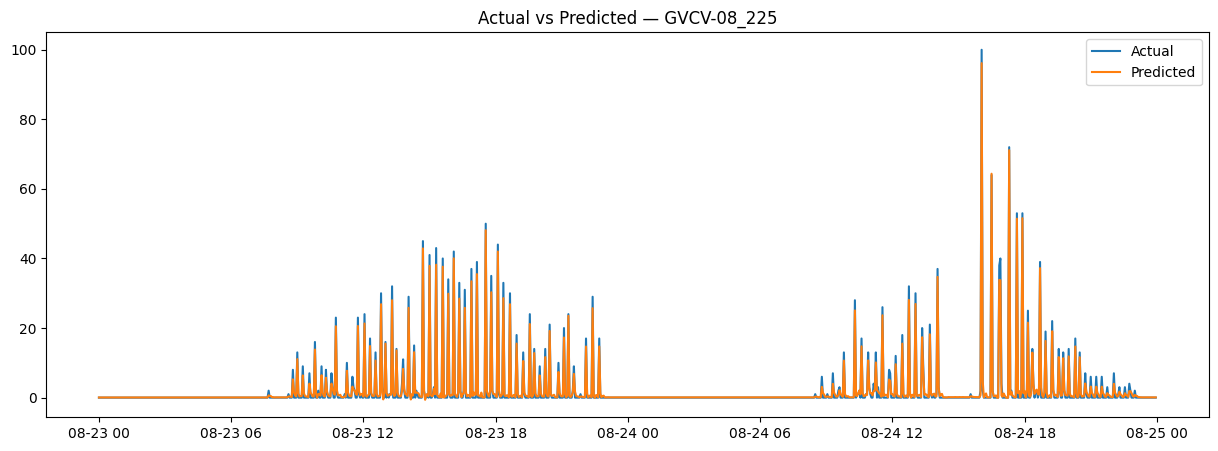

In [96]:
import matplotlib.pyplot as plt

loc = "GVCV-08_225"
loc_df = test[test['location'] == loc].set_index('timestamp')

plt.figure(figsize=(15,5))
plt.plot(loc_df['count'], label="Actual")
plt.plot(loc_df['pred'], label="Predicted")
plt.title(f"Actual vs Predicted — {loc}")
plt.legend()
plt.show()


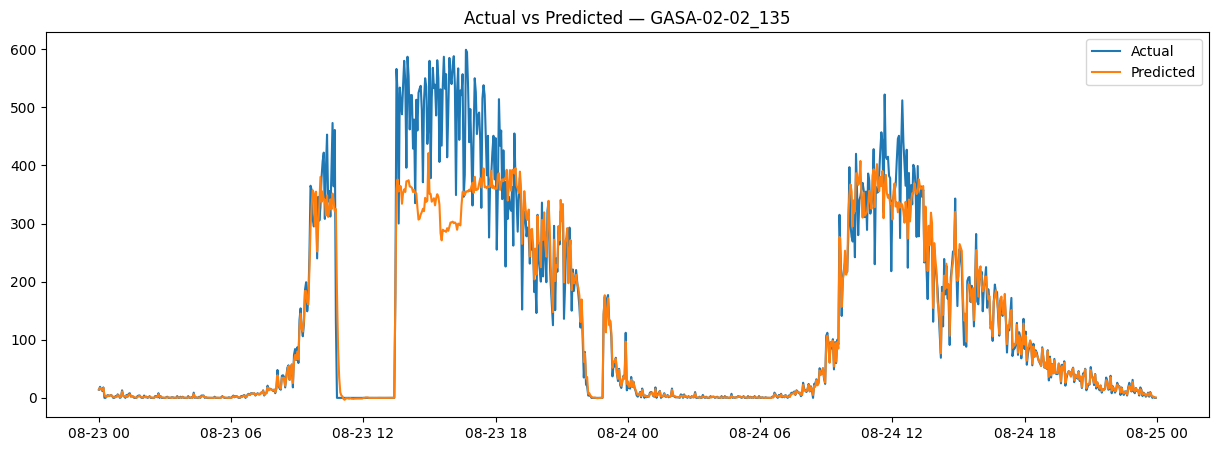

In [91]:


loc = "GASA-02-02_135"
loc_df = test[test['location'] == loc].set_index('timestamp')

plt.figure(figsize=(15,5))
plt.plot(loc_df['count'], label="Actual")
plt.plot(loc_df['pred'], label="Predicted")
plt.title(f"Actual vs Predicted — {loc}")
plt.legend()
plt.show()

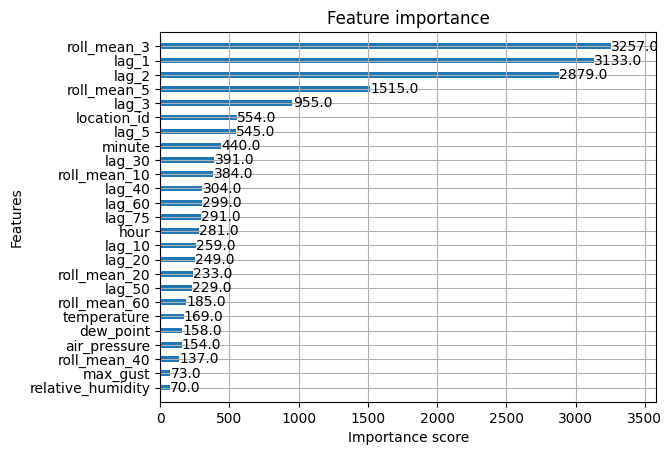

In [92]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=25, height=0.4)
plt.show()


In [93]:
# Save model

In [94]:
import joblib
joblib.dump(model, "crowd_count_model.pkl")

['crowd_count_model.pkl']